# <b>DarkVec: Automatic Analysis of Darknet Trafficwith Word Embeddings</b>
## <b>Supervised Approach: Naive Baseline</b>

___
# <b>Table of Content</b> <a id="toc_"></a>

* [<b>Baseline</b>](#baseline)
    * [k-Nearest-Neighbor Classifier](#knn)
    * [Supervised Clustering: k-Means](#kmeans)
   
In this notebook we report all the experiments related to the baseline. We generate features representing IPs by considering the top-5 ports of each ground truth class. Then, being a completely supervised approach, we run a 7-Nearest-Neighbor classifier on the last day dataset with $GT+1$ classes $= GT$ classes + Unknown:
In our experiments, $GT=9$, thus we have 10 classes.


Finally, we run the k-Means algorithm on the dataset for the classification of the 10 classes.



___
***Note:*** All the code and data we provide are the ones included in the paper. To speed up the notebook execution, by default we trim the files when reading them. Comments on how to run on complete files are provided in the notebook. Note that running the notebook with the complete dataset requires *a PC with significant amount of memory*. 

In [1]:
from src.callbacks import *
from src.kmeans import *
from src.review import *
from src.utils import split_train_test, fit_predict
from sklearn.metrics import classification_report as report
import pandas as pd
import json
import os
from config import *
import matplotlib.pyplot as plt

In [2]:
from pandas.core.common import SettingWithCopyWarning
from pandas.errors import DtypeWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=DtypeWarning)

In [3]:
%matplotlib inline
import fastplot
from cycler import cycler

cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c'])+
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

default_cc = (cycler('color',['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                      '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']))

___

# <b>Baseline</b><a id='baseline'></a>

As a very simple approach let's consider the last day of traffic. After the filtering, 
there are`G = g + 1` classes, where `g` are the ground truth classes and `G` is the number of
classes plus the `unknown`.

Assuming a port-based classifier as a baseline, we define `G`, features. Each one is the fraction
of daily packets sent to each top-5 ports for each ground truth class.

In [4]:
with open(f'{DATA}/services/services.json', 'r') as file:
    services = json.loads(file.read())

Load the last day of traffic preprocessed from raw traces.

In [5]:
# Load the last-day unfiltered
df = pd.read_csv(f'{DATASETS}/darknet_d1.csv.gz')
# Load the filters
with open(f'{DATASETS}/ips.json', 'r') as file:
    filters = json.loads(file.read())
# Apply the 30 days filter
df = df[df.ip.isin(set(filters['d1_f30']))]
#df = df[['ip','port', 'class', 'pp']].drop_duplicates()
# Convert poirt/procol pairs to lowercase
df.pp = df.pp.apply(lambda x: x.lower())
# Get the class of services
df['serv'] = df.pp.apply(lambda x: convert_pp(x, services))
# Add a ones column for packets sum
df['pkts'] = 1

df.head()

,ts,ip,port,proto,pp,class,serv,pkts
0,2021-03-31 08:29:08.449076,192.3.136.75,1970,TCP,1970/tcp,unknown,unk_usr,1
1,2021-03-31 08:29:08.449088,192.3.136.75,1970,TCP,1970/tcp,unknown,unk_usr,1
2,2021-03-31 08:29:08.451478,192.3.136.75,1970,TCP,1970/tcp,unknown,unk_usr,1
3,2021-03-31 08:29:08.451491,192.3.136.75,1970,TCP,1970/tcp,unknown,unk_usr,1
4,2021-03-31 08:29:08.459322,172.245.10.231,3956,TCP,3956/tcp,unknown,unk_usr,1


Build the baseline dataset

In [6]:
baseline = build_dataset_from_raw(df, 5)
baseline.head()

,15/tcp,3000/tcp,4222/tcp,587/tcp,5060/tcp,2000/tcp,443/tcp,445/tcp,53/udp,161/udp,...,54321/tcp,30005/tcp,2087/tcp,50000/tcp,22/tcp,9200/tcp,21/tcp,1433/tcp,123/udp,class
ip,,,,,,,,,,,,,,,,,,,,,
1.11.45.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mirai
1.14.136.104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
1.14.141.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
1.15.103.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
1.15.138.147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mirai


## <b>k-Nearest-Neighbors Classifier</b><a id='knn'></a>
We run a 7-Nearest-Neighbors classifier for evaluating the embeddings. 

In [7]:
y_true, y_pred = knn_simple_step(baseline, True, 7)
print(report(y_true, y_pred))

                 precision    recall  f1-score   support

     binaryedge       0.65      0.67      0.66       101
         censys       0.54      0.42      0.47       336
    engin-umich       0.24      1.00      0.39        10
internet-census       0.13      0.67      0.22       103
           ipip       0.00      0.00      0.00        49
          mirai       0.46      1.00      0.63      7351
           n.a.       0.00      0.00      0.00         0
      sharashka       0.53      0.32      0.40        50
         shodan       0.50      0.13      0.21        23
     stretchoid       0.05      0.03      0.04       104
        unknown       0.98      0.36      0.53     14272

       accuracy                           0.57     22399
      macro avg       0.37      0.42      0.32     22399
   weighted avg       0.79      0.57      0.56     22399



In [8]:
y_true, y_pred = knn_simple_step(baseline, False, 7)
print(report(y_true, y_pred))

                 precision    recall  f1-score   support

     binaryedge       0.97      0.67      0.80       101
         censys       0.83      0.42      0.56       336
    engin-umich       0.71      1.00      0.83        10
internet-census       0.50      0.67      0.57       103
           ipip       0.00      0.00      0.00        49
          mirai       0.97      1.00      0.98      7351
           n.a.       0.00      0.00      0.00         0
      sharashka       0.94      0.32      0.48        50
         shodan       0.75      0.13      0.22        23
     stretchoid       0.43      0.03      0.05       104
        unknown       0.00      0.00      0.00         0

       accuracy                           0.94      8127
      macro avg       0.55      0.39      0.41      8127
   weighted avg       0.94      0.94      0.93      8127



## <b>Supervised Clustering: k-Means</b><a id='kmeans'></a>

Finally, we run a k-Means with 10 classes (9 ground truth classes + 1 unknown). In this way, if the port-based classifier would be enough, each class should be assigned to a unique cluster.

In [9]:
kmeans = Kmeans(baseline, 10)
y_pred = kmeans.fit_predict()

In [10]:
baseline['cluster'] = [f'C{c}' for c in y_pred]
baseline.head()

,15/tcp,3000/tcp,4222/tcp,587/tcp,5060/tcp,2000/tcp,443/tcp,445/tcp,53/udp,161/udp,...,30005/tcp,2087/tcp,50000/tcp,22/tcp,9200/tcp,21/tcp,1433/tcp,123/udp,class,cluster
ip,,,,,,,,,,,,,,,,,,,,,
1.11.45.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mirai,C1
1.14.136.104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,C1
1.14.141.91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,C1
1.15.103.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown,C1
1.15.138.147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mirai,C0


Generate heatmap

In [11]:
pivot = pivot_clusters(baseline)
pivot

cluster,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
class,,,,,,,,,,
binaryedge,NaN,82.178218,NaN,NaN,NaN,NaN,NaN,17.821782,NaN,NaN
censys,NaN,81.547619,4.761905,NaN,NaN,NaN,NaN,8.928571,4.761905,NaN
engin-umich,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
internet-census,NaN,88.349515,NaN,NaN,NaN,NaN,NaN,11.650485,NaN,NaN
ipip,2.040816,85.714286,NaN,NaN,NaN,4.081633,NaN,2.040816,NaN,6.122449
mirai,75.853625,3.686573,NaN,NaN,10.869269,0.013604,6.053598,0.027207,3.496123,NaN
sharashka,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shodan,NaN,73.913043,NaN,NaN,NaN,NaN,NaN,26.086957,NaN,NaN
stretchoid,NaN,90.384615,0.961538,NaN,0.961538,3.846154,NaN,3.846154,NaN,NaN


<Figure size 640x480 with 0 Axes>

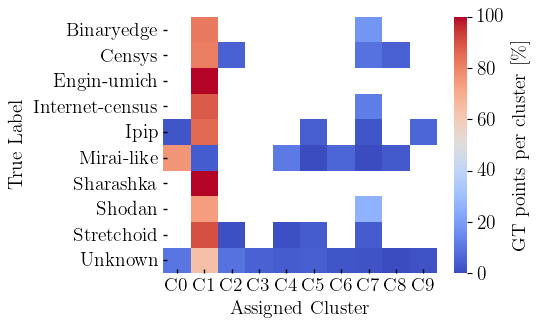

In [12]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: clustering_baseline(plt, pivot),
                     style='latex', figsize=(5.5, 3.5), fontsize=14)
plot.show()